In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.pylab import subplots, axis
import pandas as pd
import pickle
from datetime import date

In [2]:
from pyspark import SparkContext
from pyspark.sql import *

In [3]:
sc = SparkContext(master="local[2]")

In [4]:
sqlContext = SQLContext(sc)

In [5]:
import warnings
warnings.filterwarnings("ignore")

_figsize = (10, 7)

In [6]:
ny_parquet = sqlContext.read.parquet("../Data/NY.parquet/")
stations_parquet = sqlContext.read.parquet("../Data/stations.parquet/")

print("Count of NY : ", ny_parquet.count())
print("Count of STATIONS : ", stations_parquet.count())

Count of NY :  168398
Count of STATIONS :  12140


In [7]:
print("----- NY DATA -----")
ny_parquet.show(5)

----- NY DATA -----
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|361.8320007324219|42.57080078125|-77.71330261230469|2

In [8]:
# read statistics of NY data from STAT_NY.pickle
# "../data/STAT_NY.pickle" consists better overview and statistics of dataset

STAT, STAT_descr = pickle.load(open("../Data/STAT_NY.pickle", "rb"))
print("STAT keys : ", STAT.keys())

STAT keys :  dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


In [9]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_descr]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

In [10]:
print("----- STATIONS DATA -----")
stations_parquet.show(5)

----- STATIONS DATA -----
+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00341900|   739.956|    36.3| -96.4667|    242.3|   OK|       CLEVELAND|
|USC00428114|    908.22|    40.1|-111.6667|   1409.1|   UT|SPANISH FORK 1 S|
|USC00165926|   23.8801| 29.7853| -90.1158|      0.9|   LA|   MARRERO 9 SSW|
|USC00411974|   541.905| 31.5333|-101.2842|    755.9|   TX|        COPE RCH|
|USC00318906|   310.311| 35.5231| -81.4439|    274.3|   NC|    VALE AG 2 SW|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 5 rows



In [11]:
ny_parquet = ny_parquet.drop("dist_coast")
ny_parquet.show(5)

+-----------+-----------+----+--------------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1949|[BB 49 BC 49 BD 4...|42.57080078125|-77.71330261230469|208.8000030517578| 

In [12]:
joint_df = ny_parquet.join(stations_parquet, on="Station", how="left")
print("Columns : ", joint_df.columns)
joint_df.show(5)

Columns :  ['Station', 'Measurement', 'Year', 'Values', 'latitude', 'longitude', 'elevation', 'state', 'name', 'Dist_coast', 'Latitude', 'Longitude', 'Elevation', 'State', 'Name']
+-----------+-----------+----+--------------------+--------------+------------------+-----------------+-----+-----------------+----------+--------+---------+---------+-----+-----------------+
|    Station|Measurement|Year|              Values|      latitude|         longitude|        elevation|state|             name|Dist_coast|Latitude|Longitude|Elevation|State|             Name|
+-----------+-----------+----+--------------------+--------------+------------------+-----------------+-----+-----------------+----------+--------+---------+---------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|   361.832| 42.5708| -77.7133|    208.8|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|4

In [13]:
sqlContext.registerDataFrameAsTable(ny_parquet, "ny_df")

query = """
SELECT name, COUNT(name) as count
FROM ny_df
GROUP BY name
ORDER BY count DESC
"""

sqlContext.sql(query).show(5)

+--------------------+-----+
|                name|count|
+--------------------+-----+
|     SETAUKET STRONG| 1438|
|NEW YORK CNTRL PK...| 1430|
|            LOWVILLE| 1410|
|              ELMIRA| 1408|
|            ANGELICA| 1406|
+--------------------+-----+
only showing top 5 rows



In [14]:
stat = "ELMIRA"

query = """
SELECT measurement, COUNT(measurement) as count
FROM ny_df
WHERE name="%s"
GROUP BY measurement
ORDER BY count DESC
"""%stat

sqlContext.sql(query).show()

+-----------+-----+
|measurement|count|
+-----------+-----+
|   SNOW_s20|  121|
|   PRCP_s20|  121|
|       SNOW|  121|
|       PRCP|  121|
|       TMIN|  120|
|       TMAX|  120|
|   TMIN_s20|  120|
|   TMAX_s20|  120|
|   TOBS_s20|  113|
|       TOBS|  113|
|   SNWD_s20|  109|
|       SNWD|  109|
+-----------+-----+



In [15]:
query = """
SELECT year, COUNT(year) as count
FROM ny_df
WHERE name="%s"
GROUP BY year
ORDER BY count DESC
"""%stat

sqlContext.sql(query).show(5)

+----+-----+
|year|count|
+----+-----+
|1950|   12|
|1919|   12|
|1936|   12|
|1958|   12|
|1951|   12|
+----+-----+
only showing top 5 rows



In [16]:
year = 2007

query = """
SELECT *
FROM ny_df
WHERE name="%s" AND year="%d"
"""%(stat, year)

pandas_df = sqlContext.sql(query).toPandas()
pandas_df = pandas_df.set_index("Measurement")
pandas_df

,Station,Year,Values,latitude,longitude,elevation,state,name
Measurement,,,,,,,,
SNOW_s20,USC00302610,2007,"[102, 61, 227, 61, 128, 62, 17, 63, 170, 63, 7...",42.099701,-76.8358,288.600006,NY,ELMIRA
SNWD_s20,USC00302610,2007,"[170, 70, 121, 71, 48, 72, 170, 72, 45, 73, 19...",42.099701,-76.8358,288.600006,NY,ELMIRA
TOBS_s20,USC00302610,2007,"[85, 203, 22, 204, 135, 204, 255, 204, 123, 20...",42.099701,-76.8358,288.600006,NY,ELMIRA
PRCP_s20,USC00302610,2007,"[25, 76, 17, 76, 25, 76, 30, 76, 36, 76, 43, 7...",42.099701,-76.8358,288.600006,NY,ELMIRA
TMAX_s20,USC00302610,2007,"[79, 82, 17, 82, 214, 81, 149, 81, 83, 81, 15,...",42.099701,-76.8358,288.600006,NY,ELMIRA
TMIN_s20,USC00302610,2007,"[85, 209, 139, 209, 195, 209, 253, 209, 59, 21...",42.099701,-76.8358,288.600006,NY,ELMIRA
PRCP,USC00302610,2007,"[0, 69, 0, 0, 0, 0, 0, 72, 128, 86, 0, 66, 112...",42.099701,-76.8358,288.600006,NY,ELMIRA
SNOW,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",42.099701,-76.8358,288.600006,NY,ELMIRA
SNWD,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",42.099701,-76.8358,288.600006,NY,ELMIRA


In [17]:
def unpack_array(arr):
    """unpack a byte-array to numpy.ndarray"""
    return np.frombuffer(arr, dtype=np.float16)

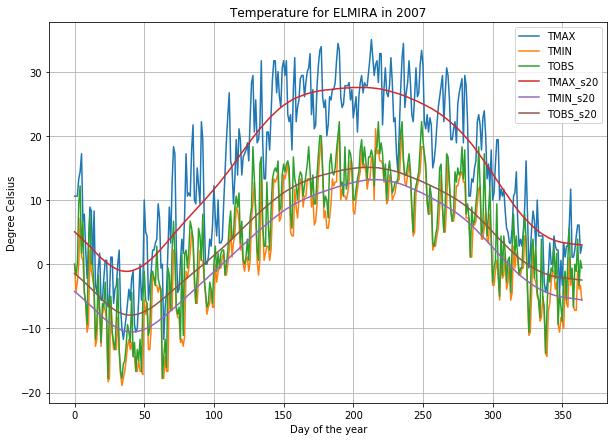

In [18]:
_tmax_20 = unpack_array(pandas_df.loc["TMAX_s20", "Values"]) / 10
_tmin_20 = unpack_array(pandas_df.loc["TMIN_s20", "Values"]) / 10
_tobs_20 = unpack_array(pandas_df.loc["TOBS_s20", "Values"]) / 10
_tmax = unpack_array(pandas_df.loc["TMAX", "Values"]) / 10
_tmin = unpack_array(pandas_df.loc["TMIN", "Values"]) / 10
_tobs = unpack_array(pandas_df.loc["TOBS", "Values"]) / 10

plt.figure(figsize=_figsize)

plt.plot(_tmax, label="TMAX")
plt.plot(_tmin, label="TMIN")
plt.plot(_tobs, label="TOBS")

plt.plot(_tmax_20, label="TMAX_s20")
plt.plot(_tmin_20, label="TMIN_s20")
plt.plot(_tobs_20, label="TOBS_s20")

plt.xlabel("Day of the year")
plt.ylabel("Degree Celsius")
plt.title("Temperature for %s in %d"%(stat, year))
plt.legend()
plt.grid()
plt.show()

In [19]:
# yearly plotter class

class YearPlotter:
    def __init__(self):
        start = 365 * 1 + 1
        self.dates = [date.fromordinal(i) for i in range(start, start + 365)]
        self.monthsFmt = DateFormatter("%b")
        self.months = MonthLocator(range(1, 13), bymonthday=1, interval=3)

    def plot(self, T, fig, ax, label='', labels=None, title=None):
        shp = np.shape(T)
        if shp[0] != 365:
            raise ValueError(
                "First dimension of T should be 365. Shape(T)="+str(np.shape(T)))
        if len(shp) == 1:
            ax.plot(self.dates, T, label=label)
        else:
            if labels is None:
                labels = [str(i) for i in range(shp[1])]
            for i in range(shp[1]):
                ax.plot(self.dates, T[:, i], label=labels[i])
        ax.xaxis.set_major_locator(self.months)
        ax.xaxis.set_major_formatter(self.monthsFmt)
        if not title is None:
            ax.set_title(title)
        fig.autofmt_xdate()
        ax.grid()
        ax.legend()

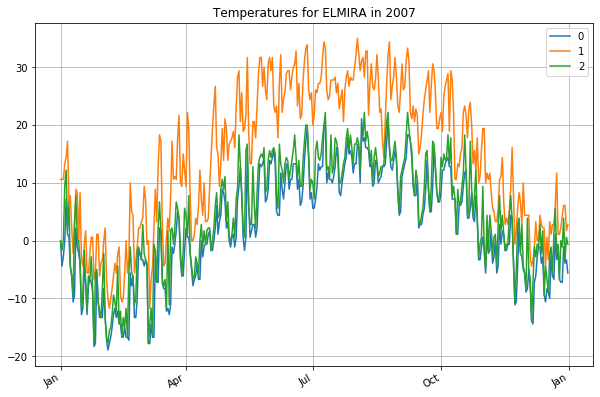

In [20]:
T = np.stack([_tmin, _tmax, _tobs])

fig, ax = plt.subplots(figsize=_figsize)
yp = YearPlotter()
yp.plot(T.transpose(), fig, ax, title='Temperatures for %s in %d' % (stat, year))

In [21]:
# distribution of missing values

def plot_pair(pair, func):
    """create two side-by-side plots"""
    j = 0
    fig, x = subplots(1, 2, figsize=(16, 6))
    axes = x.reshape(2)
    for m in pair:
        axis = axes[j]
        j += 1
        func(m, fig, axis)

In [22]:
def plot_single(element, func, filename):
    fig, axis = subplots(1, 1, figsize=(8, 6))
    func(element, fig, axis)

In [23]:
yp = YearPlotter()

def plot_valid(m, fig, axis):
    valid_m = STAT[m]["NE"]
    yp.plot(valid_m, fig, axis, title="valid-counts {}".format(m), label=m)

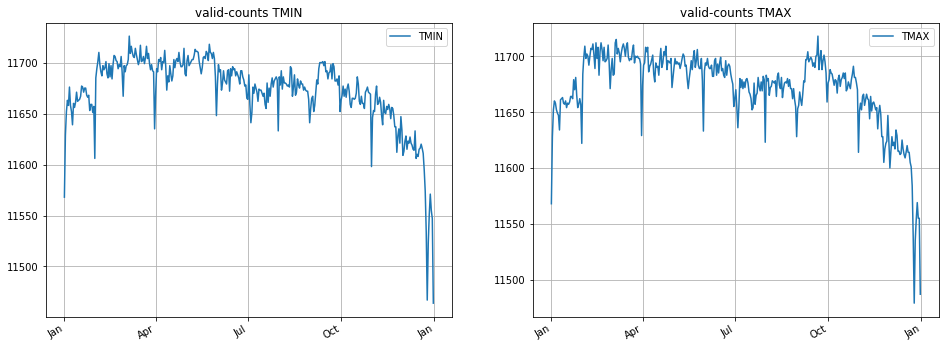

In [24]:
plot_pair(["TMIN", "TMAX"], plot_valid)

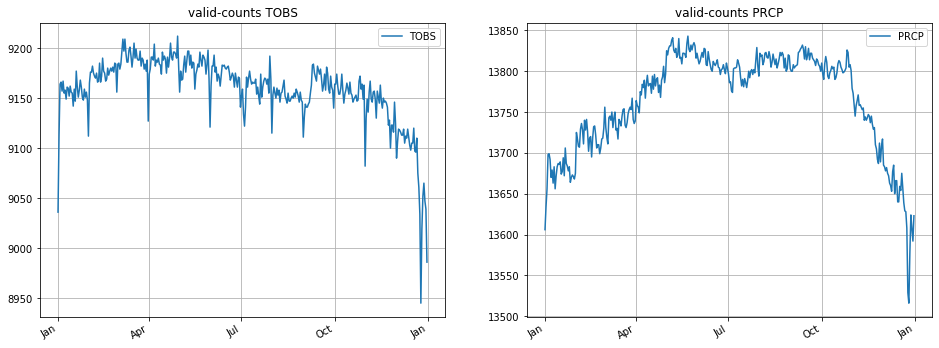

In [25]:
plot_pair(["TOBS", "PRCP"], plot_valid)

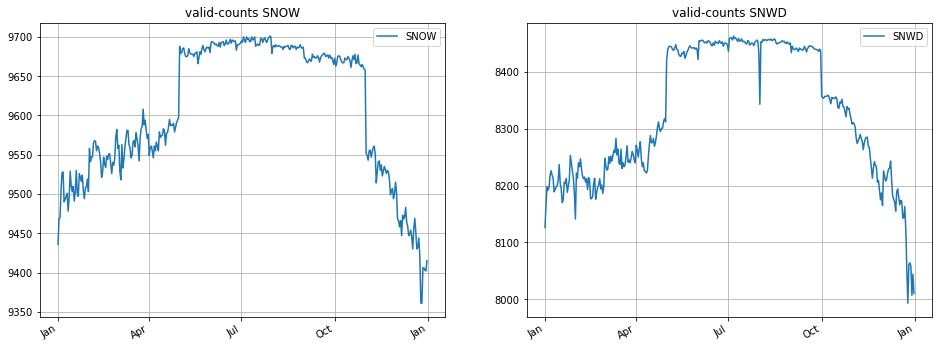

In [26]:
plot_pair(["SNOW", "SNWD"], plot_valid)

In [30]:
# plot of mean and std of observations

def plot_mean_std(m, fig, axis):
    scale = 1.
    temps = ['TMIN', 'TMAX', 'TOBS', 'TMIN_s20', 'TMAX_s20', 'TOBS_s20']
    percipitation = ['PRCP', 'SNOW', 'SNWD', 'PRCP_s20', 'SNOW_s20', 'SNWD_s20']
    _labels = ['mean + std', 'mean', 'mean - std']
    
    if (m in temps or m == 'PRCP'):
        scale = 10.
    mean = STAT[m]['Mean']/scale
    std = np.sqrt(STAT[m]['Var'])/scale
    
    graphs = np.vstack([mean + std, mean, mean - std]).transpose()
    
    yp.plot(graphs, fig, axis, labels=_labels, title='Mean +- std '+m)
    
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')

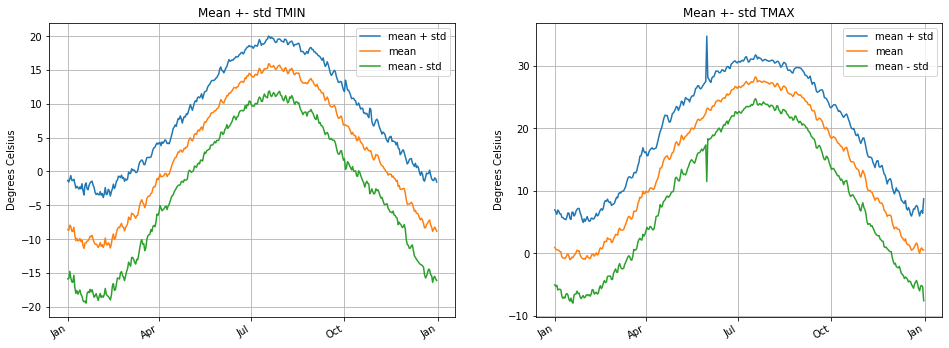

In [31]:
plot_pair(["TMIN", "TMAX"], plot_mean_std)

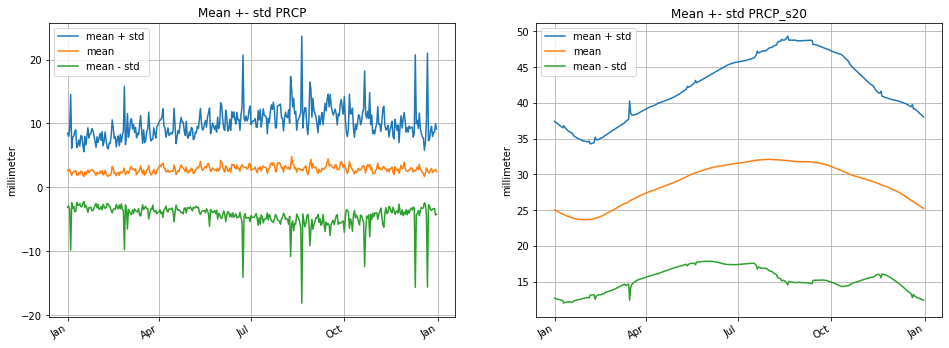

In [32]:
plot_pair(["PRCP", "PRCP_s20"], plot_mean_std)

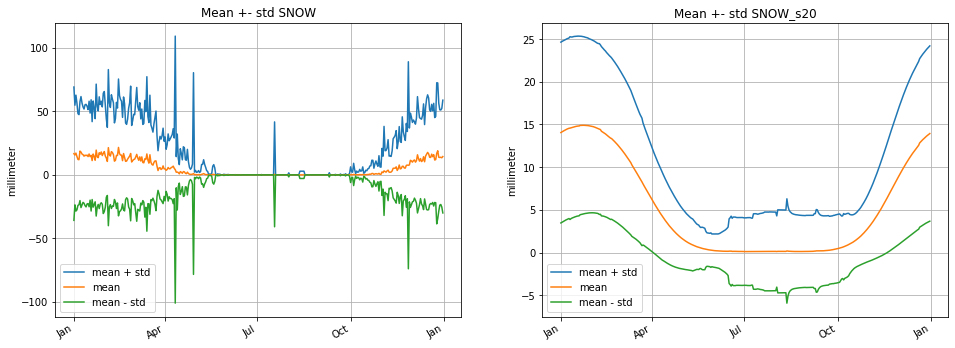

In [33]:
plot_pair(["SNOW", "SNOW_s20"], plot_mean_std)

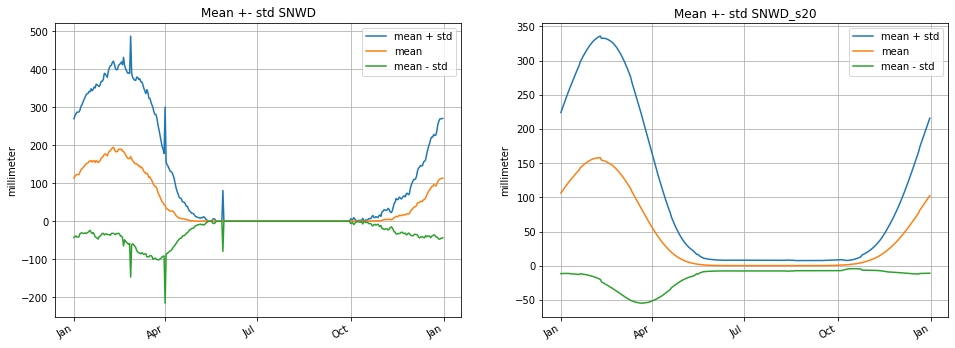

In [35]:
plot_pair(["SNWD", "SNWD_s20"], plot_mean_std)